# Cancer Research Notebook

## Import Data

In [3]:
!pip install keras-tuner
!pip install tensorflow
!pip install opencv-python
!pip install numpy
!pip install keras
!pip install -U imbalanced-learn scikit-learn
!pip install scikit-learn==0.24.2 imbalanced-learn==0.7.0



  Using cached scikit-learn-0.24.2.tar.gz (7.5 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [841 lines of output]
      <string>:17: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
      Partial import of sklearn during the build process.
      <string>:116: DeprecationWarning:
      
        `numpy.distutils` is deprecated since NumPy 1.23.0, as a result
        of the deprecation of `distutils` itself. It will be removed for
        Python >= 3.12. For older Python versions it will remain present.
        It is recommended to use `setuptools < 60.0` for those Python versions.
        For more details, see:
          https://numpy.org/devdocs/reference/distutils_status_migration.html
      
   

In [4]:
# Basic Python and Data handling libraries
import os
import pandas as pd
import numpy as np

# Sklearn libraries for preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# TensorFlow and Keras libraries for building and training the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, AUC

# Keras Tuner for Hyperparameter Tuning
from kerastuner import RandomSearch

# Libraries for visualizing the model
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/var/folders/jg/nq2krdbx0_z850_vct6mrksc0000gn/T/ipykernel_67470/3242397787.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [5]:
# Define the path to your dataset
base_dir = '/Users/aadityasurya/Desktop/Cancer Research/Dataset_BUSI_with_GT'

# Set up the directories
normal_dir = os.path.join(base_dir, 'normal')
benign_dir = os.path.join(base_dir, 'benign')
malignant_dir = os.path.join(base_dir, 'malignant')

# Function to load images and masks and associate them with correct labels
def load_images(dir, label):
    images = []
    for filename in os.listdir(dir):
        if '_mask' in filename:
            continue
        img = cv2.imread(os.path.join(dir, filename))
        if img is not None:
            img = cv2.resize(img, (150, 150))  # resize image to be sure all images have same size
            images.append(img)
    return np.array(images, dtype='object'), np.full(len(images), label, dtype=int)

# Load images
normal_images, normal_labels = load_images(normal_dir, 0)
benign_images, benign_labels = load_images(benign_dir, 1)
malignant_images, malignant_labels = load_images(malignant_dir, 2)

# Concatenate all the data
images = np.concatenate([normal_images, benign_images, malignant_images])
labels = np.concatenate([normal_labels, benign_labels, malignant_labels])

# Get the number of examples
num_examples = labels.shape[0]

# Create an array with the indexes of the examples
indexes = np.arange(num_examples)

# Shuffle the indexes
np.random.shuffle(indexes)

# Shuffle the images and labels
images = images[indexes]
labels = labels[indexes]

### Check how many instances of each label

In [8]:
import os

# Path to your dataset directory
dataset_directory = base_dir

classes = ['malignant', 'normal', 'benign']

for label in classes:
    class_dir = os.path.join(dataset_directory, label)
    
    # Checking if the path exists
    if os.path.exists(class_dir):
        count = len(os.listdir(class_dir))
        print(f"Number of {label} instances: {count}")
    else:
        print(f"{class_dir} not found!")

Number of malignant instances: 421
Number of normal instances: 266
Number of benign instances: 891


## Data Preprocessing

### One hot Encoding

In [9]:
from keras.utils import to_categorical

labels_onehot = to_categorical(labels, num_classes=3)

# Verification
print("One-hot encoding:")
print("Normal:", labels_onehot[np.where(labels == 0)][0])
print("Benign:", labels_onehot[np.where(labels == 1)][0])
print("Malignant:", labels_onehot[np.where(labels == 2)][0])


One-hot encoding:
Normal: [1. 0. 0.]
Benign: [0. 1. 0.]
Malignant: [0. 0. 1.]


### Normalize Images

In [10]:
images_normalized = images.astype('float32') / 255.0

# Verification
print("\nPixel Value Range after Normalization:")
print(f"Min: {images_normalized.min()}, Max: {images_normalized.max()}")


Pixel Value Range after Normalization:
Min: 0.0, Max: 1.0


### Splitting the Data into Train, Validation, and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(images_normalized, labels_onehot, test_size=0.2, random_state=42)
print(f"\nTrain set size: {len(X_train)}, Test set size: {len(X_test)}")

# Split the training data into 80% training and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Train set size after splitting for validation: {len(X_train)}, Validation set size: {len(X_val)}")


Train set size: 624, Test set size: 156
Train set size after splitting for validation: 499, Validation set size: 125


### Addressing Class Imbalance

#### Random Oversampling

In [12]:
def oversample_data(X, y_onehot):
    # Convert one-hot encoded labels back to single integer labels
    y = np.argmax(y_onehot, axis=1)
    
    unique_before, counts_before = np.unique(y, return_counts=True)
    print("Class distribution before oversampling:")
    for u, c in zip(unique_before, counts_before):
        print(f"Class {u}: {c} samples")
    
    max_count = np.max(counts_before)

    X_over = X.copy()
    y_over = y_onehot.copy()

    for u, c in zip(unique_before, counts_before):
        samples_needed = max_count - c
        if samples_needed > 0:
            X_temp = X[y == u]
            y_temp = y_onehot[y == u]
            for _ in range(samples_needed):
                idx = np.random.choice(len(X_temp))
                X_over = np.append(X_over, [X_temp[idx]], axis=0)
                y_over = np.append(y_over, [y_temp[idx]], axis=0)
    
    unique_after, counts_after = np.unique(np.argmax(y_over, axis=1), return_counts=True)
    print("\nClass distribution after oversampling:")
    for u, c in zip(unique_after, counts_after):
        print(f"Class {u}: {c} samples")
    
    return X_over, y_over

X_train_resampled, y_train_resampled = oversample_data(X_train, y_train)


Class distribution before oversampling:
Class 0: 78 samples
Class 1: 285 samples
Class 2: 136 samples

Class distribution after oversampling:
Class 0: 285 samples
Class 1: 285 samples
Class 2: 285 samples


### Shuffle Training Data

In [13]:
shuffle_indexes = np.arange(X_train_resampled.shape[0])
np.random.shuffle(shuffle_indexes)

X_train_resampled = X_train_resampled[shuffle_indexes]
y_train_resampled = y_train_resampled[shuffle_indexes]

# Verification
print("\nData has been shuffled.")


Data has been shuffled.


## Data Augmentation and Train Test Val Split

### Data Augmentation

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Data Augmentation without the normalization step (normalization has been done already)
datagen = ImageDataGenerator(
    rotation_range=5,  # Reduced rotation
    width_shift_range=0.05,  # Reduced width shift
    height_shift_range=0.05,  # Reduced height shift
    shear_range=0.05,  # Reduced shear range
    zoom_range=0.05,  # Reduced zoom
    horizontal_flip=True,
    fill_mode='nearest',
    data_format="channels_last"
)

# Apply the data augmentation
augmented_images = []
augmented_labels = []

for i in range(len(X_train_resampled)):
    # Resize the image to the target size
    resized_image = tf.image.resize(X_train_resampled[i:i+1], [224, 224])
    
    # Produce one augmented image
    aug_iter = datagen.flow(resized_image, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.float32)
    augmented_images.append(aug_image)
    augmented_labels.append(y_train_resampled[i])

augmented_images = np.array(augmented_images, dtype=np.float32).squeeze()  # Added .squeeze() to remove extra dimensions
augmented_labels = np.array(augmented_labels, dtype=np.float32)

# Verification
print(f"Augmented dataset size: {len(augmented_images)}")
print(f"Shape of augmented images: {augmented_images[0].shape}")  # This should display (224, 224, 3)

Augmented dataset size: 855
Shape of augmented images: (224, 224, 3)


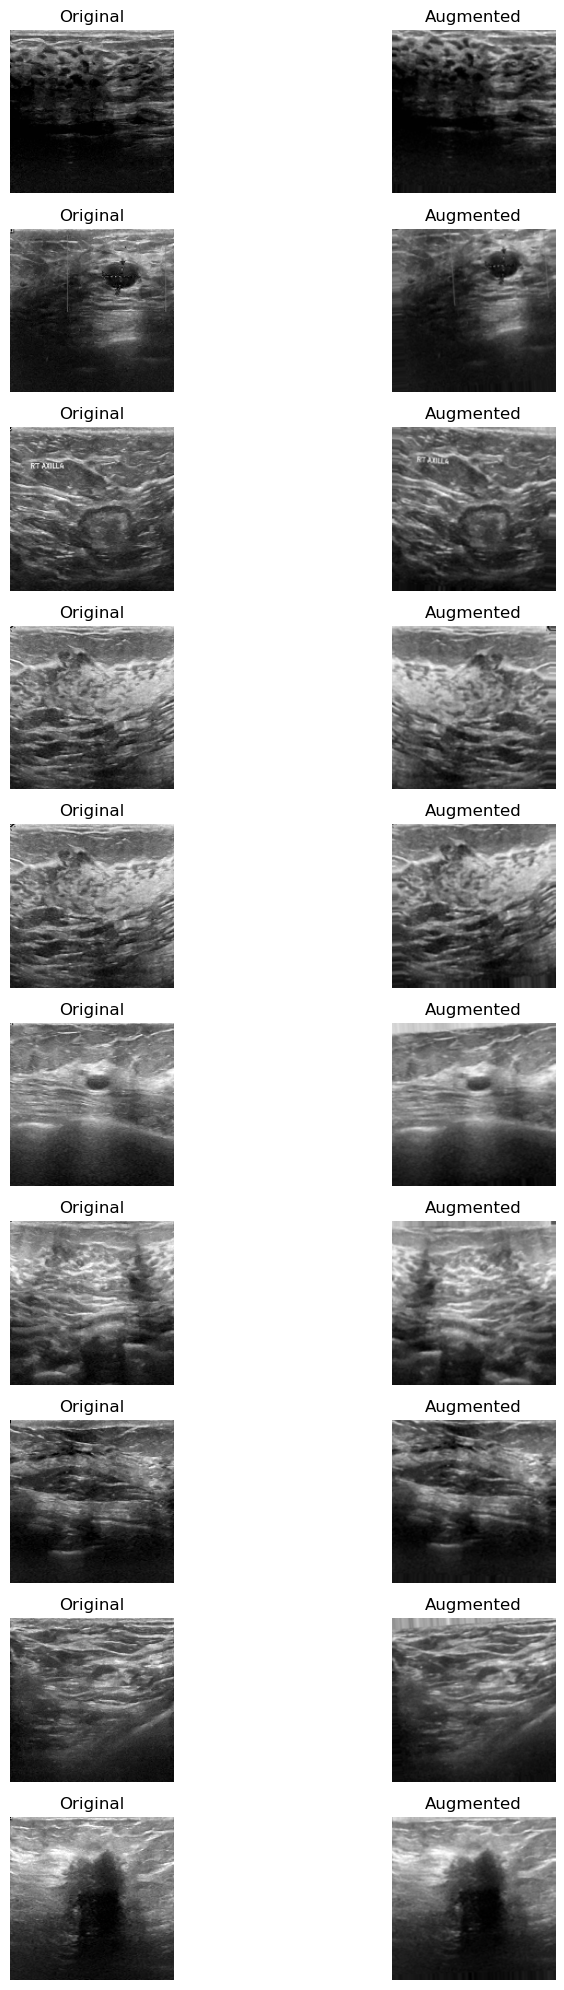

In [15]:
import matplotlib.pyplot as plt

# Function to plot original and augmented images side by side
def plot_samples(original_samples, augmented_samples, n=10):
    """
    Display the first n images from the original and augmented datasets.
    """
    fig, axes = plt.subplots(n, 2, figsize=(10, 20))

    for i in range(n):
        axes[i, 0].imshow(original_samples[i, :, :, 0], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Original')

        axes[i, 1].imshow(augmented_samples[i, :, :, 0], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Augmented')

    plt.tight_layout()
    plt.show()

# Display the first 10 images from the original and augmented datasets
plot_samples(X_train_resampled, augmented_images, n=10)


### Data Splitting

In [16]:
from sklearn.model_selection import train_test_split

# Assuming augmented_images and augmented_labels are your datasets
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 598
Validation set size: 128
Test set size: 129


### Batching

In [17]:
batch_size = 32
num_batches = len(augmented_images) // batch_size + (1 if len(augmented_images) % batch_size else 0)

# Create batches
image_batches = [augmented_images[i:i+batch_size] for i in range(0, len(augmented_images), batch_size)]
label_batches = [augmented_labels[i:i+batch_size] for i in range(0, len(augmented_labels), batch_size)]

# Verification
print(f"Batching Complete.")
print(f"Number of batches created: {num_batches}")
print(f"Batch size: {batch_size}")
print(f"Number of images in the last batch: {len(image_batches[-1])}")

Batching Complete.
Number of batches created: 27
Batch size: 32
Number of images in the last batch: 23


### Plot of Sample Images

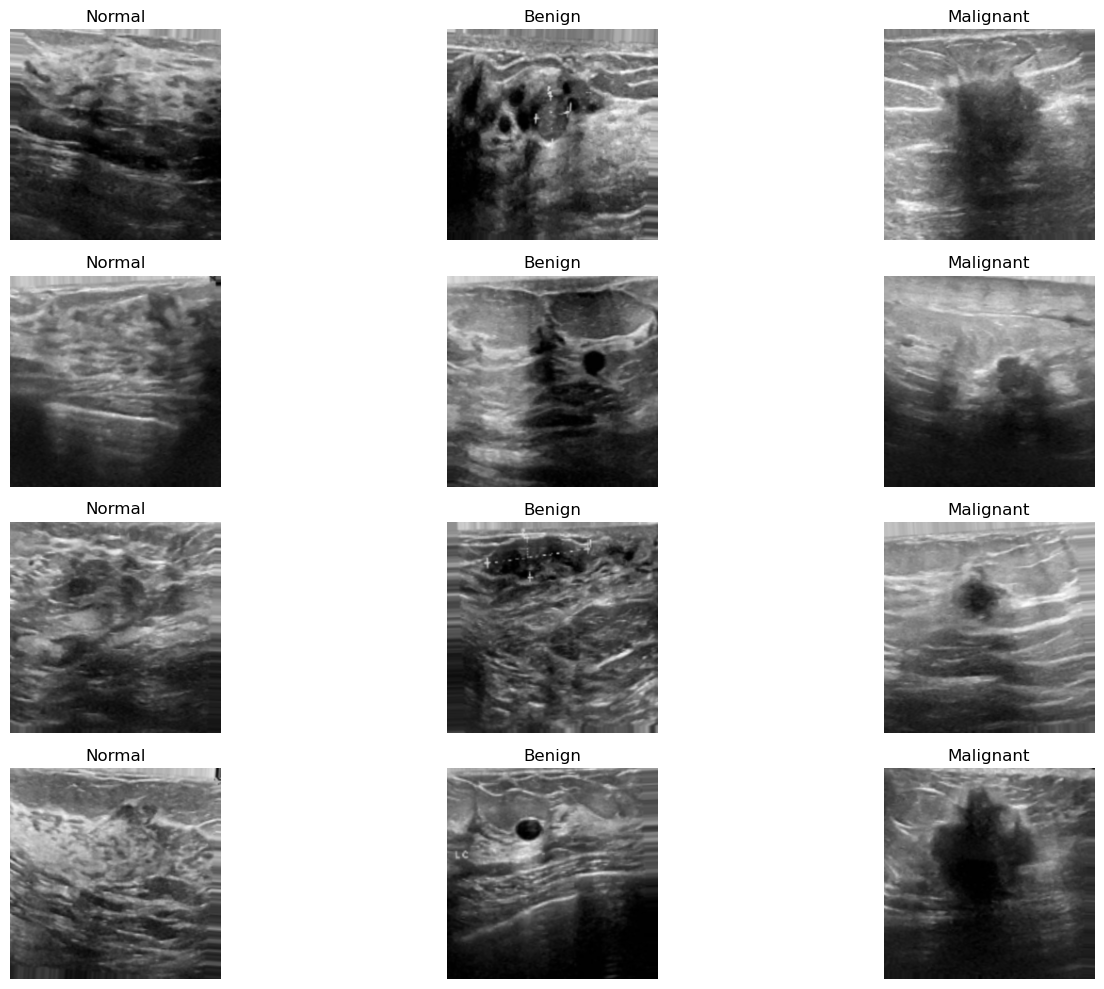

In [18]:
import matplotlib.pyplot as plt

def plot_samples(images, labels, label_names, samples_per_label=4):
    fig, axes = plt.subplots(samples_per_label, len(label_names), figsize=(15, 10))
    
    for label_index, label_name in enumerate(label_names):
        # Find indices of this label
        label_indices = [i for i, label in enumerate(labels) if label == label_index]
        
        # Randomly select samples
        selected_indices = np.random.choice(label_indices, samples_per_label, replace=False)
        
        for sample_index, image_index in enumerate(selected_indices):
            ax = axes[sample_index, label_index]
            ax.imshow(images[image_index].squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
            ax.set_title(label_name)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming the labels are in one-hot encoded format, we convert them back to integer labels for easier processing
integer_labels = np.argmax(augmented_labels, axis=1)
label_names = ['Normal', 'Benign', 'Malignant']  # Replace with your actual class names

plot_samples(augmented_images, integer_labels, label_names)


## Model Building + Hyperparameter Tuning

### Check if images are RGB or Grayscale

In [ ]:
sample_image = X_train_resampled[0]

if len(sample_image.shape) == 2 or sample_image.shape[2] == 1:
    print("The images are grayscale.")
elif sample_image.shape[2] == 3:
    print("The images are RGB.")
else:
    print("Unexpected image format.")

The images are RGB.


### Create the Model (Transfer Learning from MobileNetV2)

In [ ]:
# Import Libraries (this may be redundant but just incase any libraries are not imported above)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
import kerastuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

from tensorflow.keras.optimizers.legacy import Adam  # Use the legacy version for M1/M2 Macbooks


In [ ]:
from tensorflow.keras.regularizers import l2

def build_model(hp):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers of the pre-trained model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add L2 regularization to the Dense layer
    x = Dense(units=hp.Int('units', min_value=512, max_value=2048, step=256),
              activation='relu',
              kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG')))(x)

    # Keep dropout as it's a good regularization technique
    x = Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1))(x)
    
    predictions = Dense(3, activation='softmax', kernel_regularizer=l2(hp.Float('l2_reg_dense', min_value=1e-5, max_value=1e-2, sampling='LOG')))(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=[
                      'accuracy',
                      Precision(name='precision'),
                      Recall(name='recall')
                  ])
    
    return model


### Use Keras Tuner to Find Hyperparameters

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(augmented_images, augmented_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

# Keras Tuner setup
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Reduced number of trials
    executions_per_trial=1,  # Reduced number of executions
    directory='tuner_directory',
    project_name='cnn_cancer_prediction')

print("Starting the search for the best hyperparameters...")

# Start the search for the best hyperparameters
tuner.search(X_train, y_train,
             epochs=3,  # Reduced number of epochs per trial
             validation_data=(X_val, y_val))

print("\nSearch for hyperparameters is completed.")

# Save the best model / hyperparameters
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

# Print relevant information about the best model and its hyperparameters
print("\nBest Model Summary:")
best_model.summary()

print("\nBest Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

print("\nAll tasks are completed!")

Training set size: 598
Validation set size: 128
Test set size: 129
INFO:tensorflow:Reloading Tuner from tuner_directory/cnn_cancer_prediction/tuner0.json


INFO:tensorflow:Reloading Tuner from tuner_directory/cnn_cancer_prediction/tuner0.json


Starting the search for the best hyperparameters...
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit



Search for hyperparameters is completed.

Best Model Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

### Compile and Train Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import f1_score, matthews_corrcoef, average_precision_score, roc_auc_score

# Define a function to calculate additional metrics during training
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
    
    def on_epoch_end(self, epoch, logs=None):
        val_pred = self.model.predict(self.validation_data[0])
        val_true = self.validation_data[1]
        
        val_f1 = f1_score(np.argmax(val_true, axis=1), np.argmax(val_pred, axis=1), average='weighted')
        val_mcc = matthews_corrcoef(np.argmax(val_true, axis=1), np.argmax(val_pred, axis=1))
        val_prauc = average_precision_score(val_true, val_pred, average='weighted')
        val_rocauc = roc_auc_score(val_true, val_pred, average='weighted')
        
        print(f"Val F1-Score: {val_f1:.4f} - Val MCC: {val_mcc:.4f} - Val PR AUC: {val_prauc:.4f} - Val ROC AUC: {val_rocauc:.4f}")

# Compile the best model with the obtained hyperparameters
best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
                   loss='categorical_crossentropy',
                   metrics=[
                       'accuracy',
                       Precision(name='precision'),
                       Recall(name='recall')
                   ])

# Define callback functions
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
metrics_callback = MetricsCallback(validation_data=(X_val, y_val))

# Adjusted patience for early stopping and reduce LR
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)


# Fit the model with callbacks
history = best_model.fit(X_train, y_train,
                         epochs=50,
                         batch_size=16,  # Reduced batch size
                         validation_data=(X_val, y_val),
                         callbacks=[early_stopping, model_checkpoint, reduce_lr, metrics_callback],
                         verbose=1)

# Evaluate the model on the test set
test_metrics = best_model.evaluate(X_test, y_test, verbose=0)

# Print test metrics
print("\nTest Metrics:")
print(f"Loss: {test_metrics[0]}")
print(f"Accuracy: {test_metrics[1]}")
print(f"Precision: {test_metrics[2]}")
print(f"Recall: {test_metrics[3]}")

print("\nAll tasks are completed!")


Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.7391 - precision: 0.7731 - recall: 0.7007

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 130ms/step
Val F1-Score: 0.7498 - Val MCC: 0.6361 - Val PR AUC: 0.8957 - Val ROC AUC: 0.9368
38/38 [==============================] - 6s 145ms/step - loss: 0.6389 - accuracy: 0.7391 - precision: 0.7731 - recall: 0.7007 - val_loss: 0.5309 - val_accuracy: 0.7500 - val_precision: 0.8034 - val_recall: 0.7344 - lr: 0.0013
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 0.4084 - accuracy: 0.8294 - precision: 0.8518 - recall: 0.8057
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.000665334751829505.
4/4 [==============================] - 1s 128ms/step
Val F1-Score: 0.7213 - Val MCC: 0.6059 - Val PR AUC: 0.8897 - Val ROC AUC: 0.9285
38/38 [==============================] - 4s 115ms/step - loss: 0.4073 - accuracy: 0.8311 - precision: 0.8534 - recall: 0.8077 - val_loss: 0.6411 - val_accuracy: 0.7266 - val_precision: 0.7436 - val_recall: 0.6797 - lr: 0.0013
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 0.32

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 127ms/step
Val F1-Score: 0.7791 - Val MCC: 0.6781 - Val PR AUC: 0.9210 - Val ROC AUC: 0.9549
38/38 [==============================] - 4s 119ms/step - loss: 0.3248 - accuracy: 0.8763 - precision: 0.8955 - recall: 0.8595 - val_loss: 0.4631 - val_accuracy: 0.7812 - val_precision: 0.8017 - val_recall: 0.7578 - lr: 6.6533e-04
Epoch 4/50
37/38 [============================>.] - ETA: 0s - loss: 0.2479 - accuracy: 0.9054 - precision: 0.9187 - recall: 0.8970

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 129ms/step
Val F1-Score: 0.7988 - Val MCC: 0.7039 - Val PR AUC: 0.9186 - Val ROC AUC: 0.9514
38/38 [==============================] - 4s 116ms/step - loss: 0.2457 - accuracy: 0.9064 - precision: 0.9195 - recall: 0.8980 - val_loss: 0.4579 - val_accuracy: 0.7969 - val_precision: 0.8250 - val_recall: 0.7734 - lr: 6.6533e-04
Epoch 5/50
37/38 [============================>.] - ETA: 0s - loss: 0.2039 - accuracy: 0.9291 - precision: 0.9444 - recall: 0.9189
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003326673759147525.
4/4 [==============================] - 1s 131ms/step
Val F1-Score: 0.7970 - Val MCC: 0.7093 - Val PR AUC: 0.9221 - Val ROC AUC: 0.9534
38/38 [==============================] - 4s 116ms/step - loss: 0.2046 - accuracy: 0.9298 - precision: 0.9450 - recall: 0.9197 - val_loss: 0.4647 - val_accuracy: 0.7969 - val_precision: 0.8115 - val_recall: 0.7734 - lr: 6.6533e-04
Epoch 6/50
37/38 [============================>.] - ETA: 0s - l

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 127ms/step
Val F1-Score: 0.7945 - Val MCC: 0.7030 - Val PR AUC: 0.9243 - Val ROC AUC: 0.9565
38/38 [==============================] - 4s 119ms/step - loss: 0.1379 - accuracy: 0.9649 - precision: 0.9711 - recall: 0.9565 - val_loss: 0.4538 - val_accuracy: 0.7969 - val_precision: 0.8167 - val_recall: 0.7656 - lr: 1.6633e-04
Epoch 8/50
37/38 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9645 - precision: 0.9743 - recall: 0.9611

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 128ms/step
Val F1-Score: 0.7883 - Val MCC: 0.6875 - Val PR AUC: 0.9261 - Val ROC AUC: 0.9576
38/38 [==============================] - 4s 116ms/step - loss: 0.1296 - accuracy: 0.9649 - precision: 0.9746 - recall: 0.9615 - val_loss: 0.4253 - val_accuracy: 0.7891 - val_precision: 0.8080 - val_recall: 0.7891 - lr: 1.6633e-04
Epoch 9/50
37/38 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9747 - precision: 0.9761 - recall: 0.9679
Epoch 9: ReduceLROnPlateau reducing learning rate to 8.316684397868812e-05.
4/4 [==============================] - 1s 129ms/step
Val F1-Score: 0.7883 - Val MCC: 0.6875 - Val PR AUC: 0.9258 - Val ROC AUC: 0.9571
38/38 [==============================] - 4s 115ms/step - loss: 0.1216 - accuracy: 0.9749 - precision: 0.9764 - recall: 0.9682 - val_loss: 0.4325 - val_accuracy: 0.7891 - val_precision: 0.8065 - val_recall: 0.7812 - lr: 1.6633e-04
Epoch 10/50
37/38 [============================>.] - ETA: 0s - 

/Users/aadityasurya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 132ms/step
Val F1-Score: 0.8123 - Val MCC: 0.7201 - Val PR AUC: 0.9260 - Val ROC AUC: 0.9570
38/38 [==============================] - 5s 120ms/step - loss: 0.1139 - accuracy: 0.9833 - precision: 0.9865 - recall: 0.9749 - val_loss: 0.4085 - val_accuracy: 0.8125 - val_precision: 0.8226 - val_recall: 0.7969 - lr: 8.3167e-05
Epoch 11/50
37/38 [============================>.] - ETA: 0s - loss: 0.1089 - accuracy: 0.9814 - precision: 0.9846 - recall: 0.9747
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.158342198934406e-05.
4/4 [==============================] - 1s 132ms/step
Val F1-Score: 0.7968 - Val MCC: 0.6984 - Val PR AUC: 0.9246 - Val ROC AUC: 0.9567
38/38 [==============================] - 4s 116ms/step - loss: 0.1098 - accuracy: 0.9799 - precision: 0.9831 - recall: 0.9732 - val_loss: 0.4309 - val_accuracy: 0.7969 - val_precision: 0.8016 - val_recall: 0.7891 - lr: 8.3167e-05
Epoch 12/50
38/38 [==============================] - ETA: 0s 

### Save Model and Training (when runtime resets we will still have the data to evaluate)

In [ ]:
import pickle

# Save the trained model
best_model.save('best_model.keras')

# Save the training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Model and training history saved successfully!")
print("Best model is saved as 'best_model.keras'")
print("Training history is saved as 'training_history.pkl'")
print("\nAll tasks are completed!")

Model and training history saved successfully!
Best model is saved as 'best_model.keras'
Training history is saved as 'training_history.pkl'

All tasks are completed!


## Model Evaluation

### Training Metric Graphs

In [19]:
import pickle

# Load training history
with open('training_history.pkl', 'rb') as file:
    training_history = pickle.load(file)

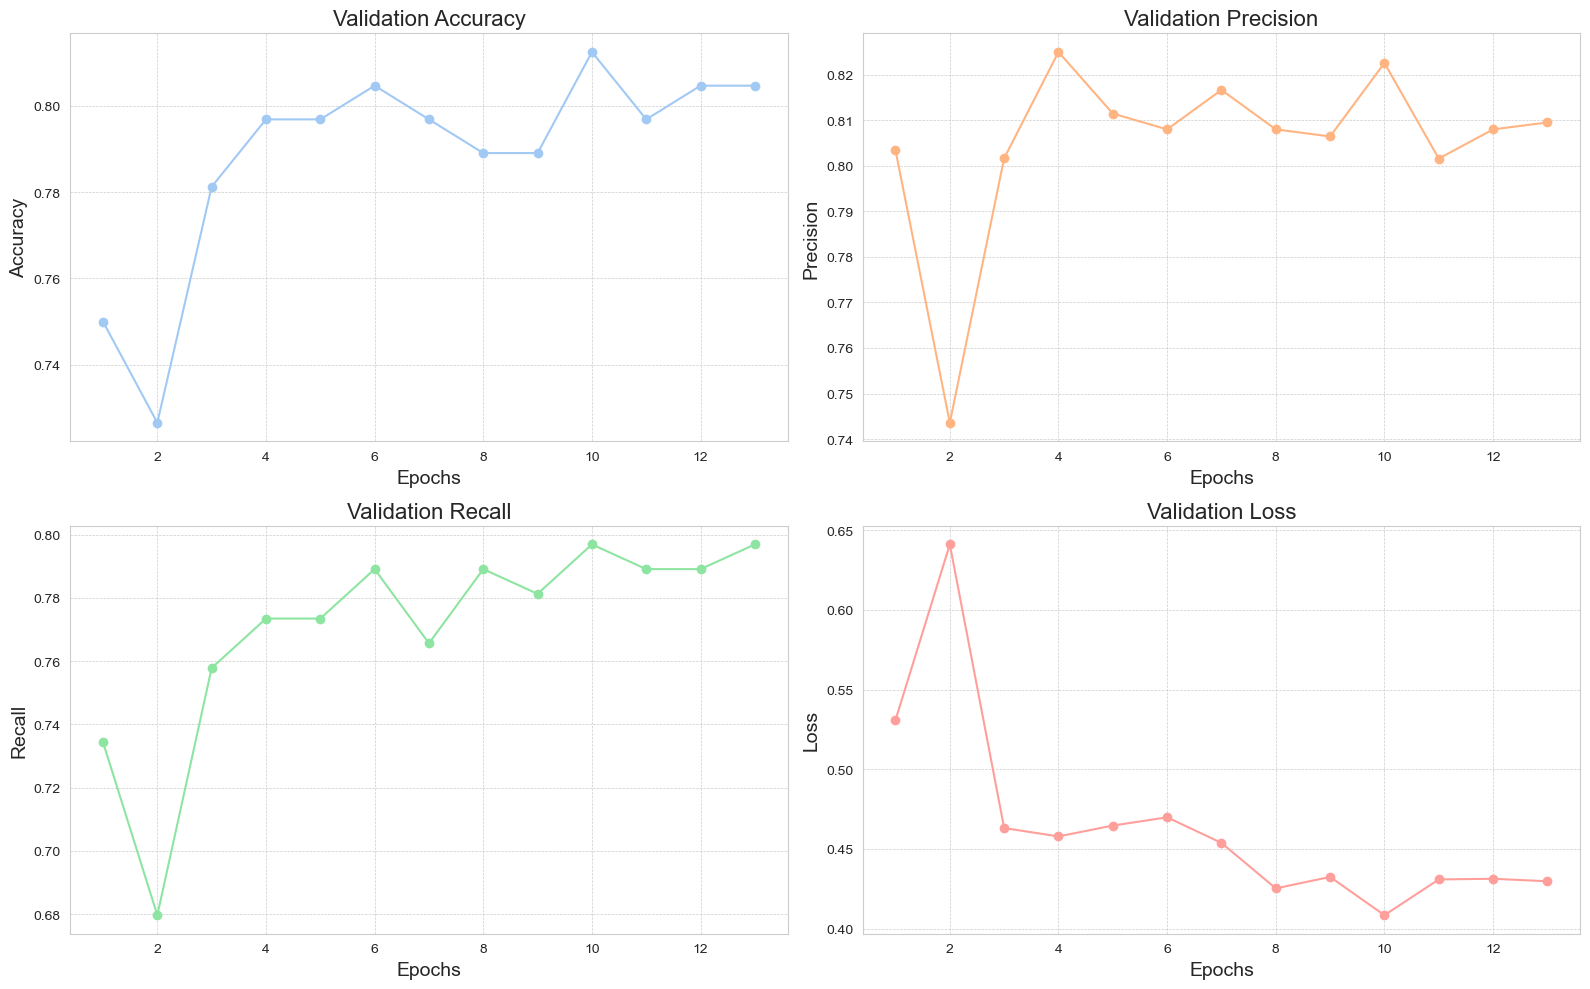

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set_style("whitegrid")
palette = sns.color_palette("pastel")

# Extract metrics from training history
val_accuracy = training_history['val_accuracy']
val_precision = training_history['val_precision']
val_recall = training_history['val_recall']
val_loss = training_history['val_loss']

epochs = range(1, len(val_accuracy) + 1)

plt.figure(figsize=(16, 10))

# Plot validation accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, val_accuracy, marker='o', linestyle='-', color=palette[0])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Validation Accuracy', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation precision
plt.subplot(2, 2, 2)
plt.plot(epochs, val_precision, marker='o', linestyle='-', color=palette[1])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Validation Precision', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation recall
plt.subplot(2, 2, 3)
plt.plot(epochs, val_recall, marker='o', linestyle='-', color=palette[2])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Validation Recall', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot validation loss
plt.subplot(2, 2, 4)
plt.plot(epochs, val_loss, marker='o', linestyle='-', color=palette[3])
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Validation Loss', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig("validation_metrics.png", dpi=300)  # Save the figure in high resolution
plt.show()


### Evaluate on Test Data

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the best saved model
best_model = tf.keras.models.load_model('best_model.h5')

# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate and print out various metrics based on these predictions
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_true_classes, y_pred_classes))

# If you want to see accuracy, precision, recall for the test set using Keras functions
test_metrics = best_model.evaluate(X_test, y_test, verbose=1)
print("\nTest Metrics from Keras:")
print(f"Loss: {test_metrics[0]:.4f}")
print(f"Accuracy: {test_metrics[1]:.4f}")
print(f"Precision: {test_metrics[2]:.4f}")
print(f"Recall: {test_metrics[3]:.4f}")

5/5 [==============================] - 1s 117ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        51
           1       0.79      0.68      0.73        40
           2       0.79      0.89      0.84        38

    accuracy                           0.81       129
   macro avg       0.80      0.80      0.80       129
weighted avg       0.81      0.81      0.80       129


Confusion Matrix:

[[43  7  1]
 [ 5 27  8]
 [ 4  0 34]]
5/5 [==============================] - 1s 116ms/step - loss: 0.5295 - accuracy: 0.8062 - precision: 0.8226 - recall: 0.7907

Test Metrics from Keras:
Loss: 0.5295
Accuracy: 0.8062
Precision: 0.8226
Recall: 0.7907


#### Display Metrics in a Table

In [22]:
import pandas as pd

# Gather metrics
data = {
    "Loss": [test_metrics[0]],
    "Accuracy": [test_metrics[1]],
    "Precision": [test_metrics[2]],
    "Recall": [test_metrics[3]]
}

df_metrics = pd.DataFrame(data)
print(df_metrics)

       Loss  Accuracy  Precision    Recall
0  0.529535  0.806202   0.822581  0.790698


#### Confusion Matrix Visualization

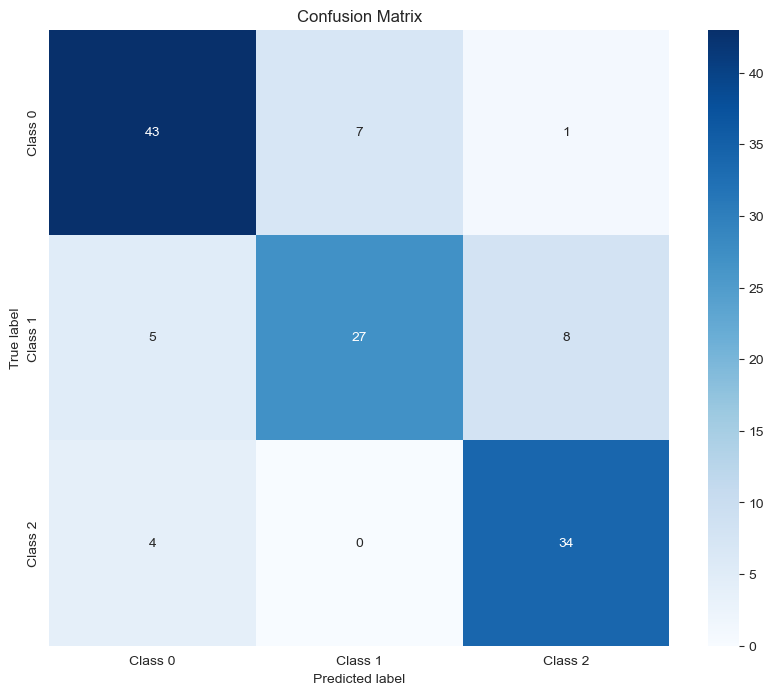

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1', 'Class 2'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

#### ROC-AUC and PR-AUC Graph

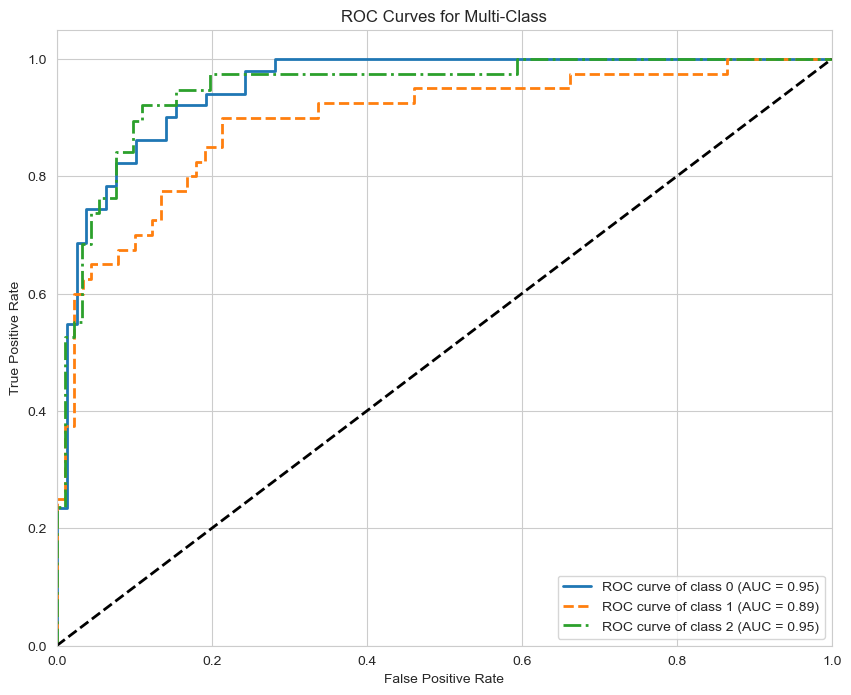

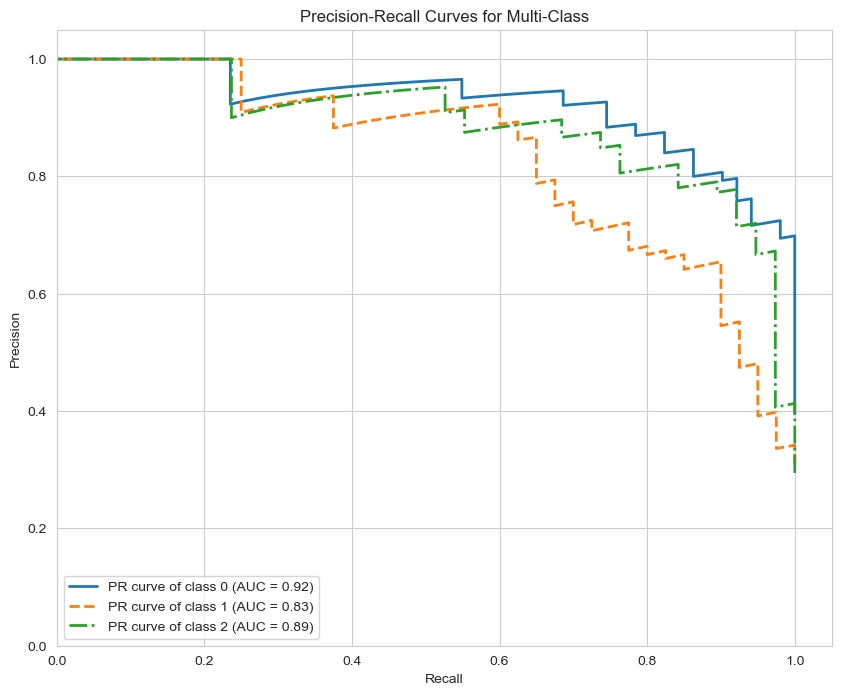

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Set the aesthetics for seaborn
sns.set_style("whitegrid")

num_classes = 3
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c'])
linestyles = cycle(['-', '--', '-.'])

# ROC Curves
plt.figure(figsize=(10, 8))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=next(colors), linestyle=next(linestyles), lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# PR Curves
plt.figure(figsize=(10, 8))

precision = dict()
recall = dict()
pr_auc = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    pr_auc[i] = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall[i], precision[i], color=next(colors), linestyle=next(linestyles), lw=2,
             label='PR curve of class {0} (AUC = {1:0.2f})'.format(i, pr_auc[i]))

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Multi-Class')
plt.legend(loc="lower left")
plt.show()


#### Loss Curve

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetics for seaborn
sns.set_style("whitegrid")

# Plotting the loss curve
plt.figure(figsize=(10, 8))

plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linestyle='--')

plt.title('Training and Validation Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

NameError: name 'history' is not defined

<Figure size 1000x800 with 0 Axes>

#### Error Analysis

5/5 [==============================] - 1s 123ms/step


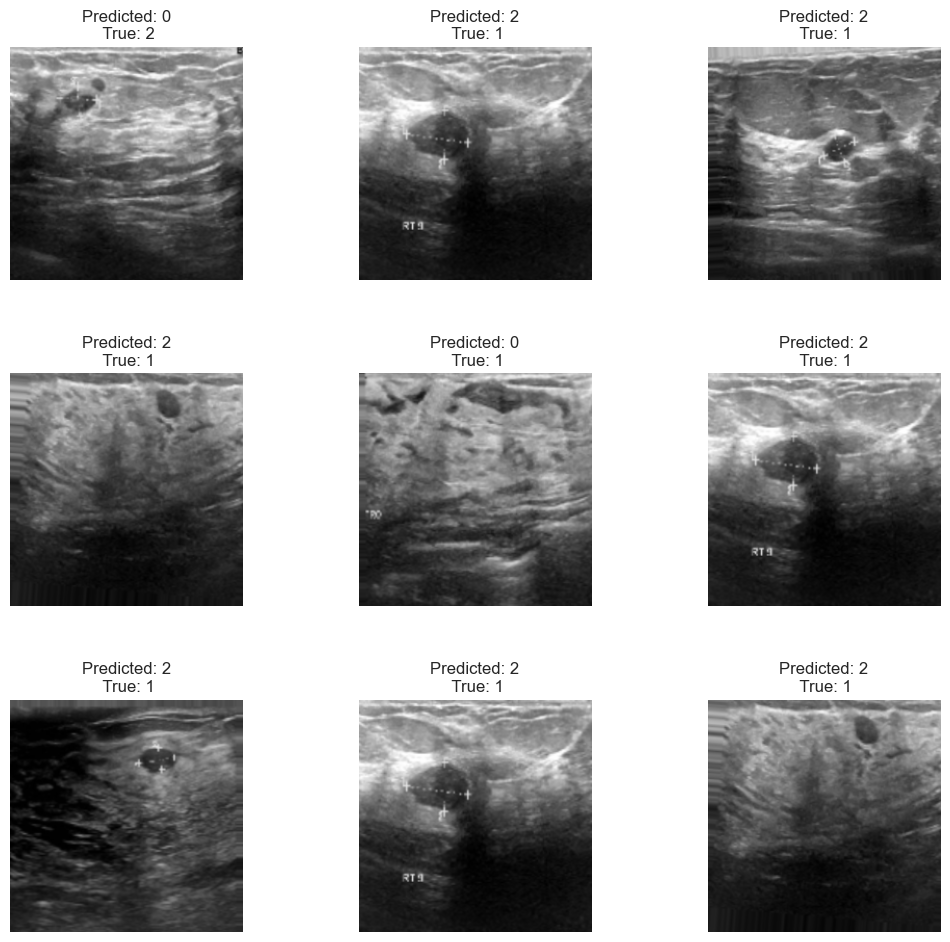

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Predict classes
y_pred_classes = np.argmax(best_model.predict(X_test), axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)

# Identify misclassified indices
misclassified_idx = np.where(y_pred_classes != y_true_classes)[0]

# Display some of the misclassified images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 9):
    idx = np.random.choice(misclassified_idx)
    axes[i].imshow(X_test[idx])
    axes[i].set_title(f"Predicted: {y_pred_classes[idx]}\n True: {y_true_classes[idx]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Data Visualization

### Distribution of Image Intensities

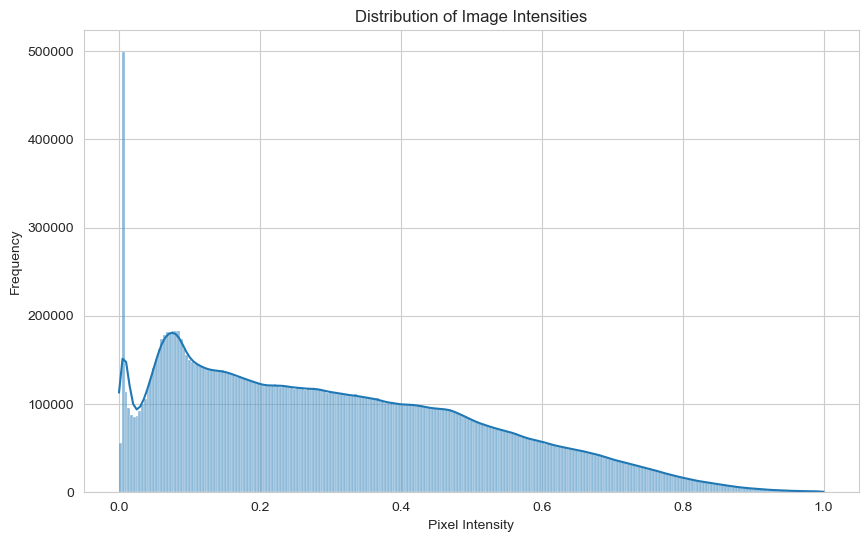

In [30]:
plt.figure(figsize=(10,6))
sns.histplot(X_test.ravel(), kde=True, bins=255)
plt.title('Distribution of Image Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


### Boxplots for Image Intensity by Class


Summary Statistics for Normal:
Min: 0.16
Q1 (25th Percentile): 0.25
Median: 0.30
Q3 (75th Percentile): 0.34
Max: 0.44
No outliers found.

Summary Statistics for Benign:
Min: 0.16
Q1 (25th Percentile): 0.28
Median: 0.33
Q3 (75th Percentile): 0.41
Max: 0.51
No outliers found.

Summary Statistics for Malignant:
Min: 0.14
Q1 (25th Percentile): 0.22
Median: 0.28
Q3 (75th Percentile): 0.36
Max: 0.47
No outliers found.


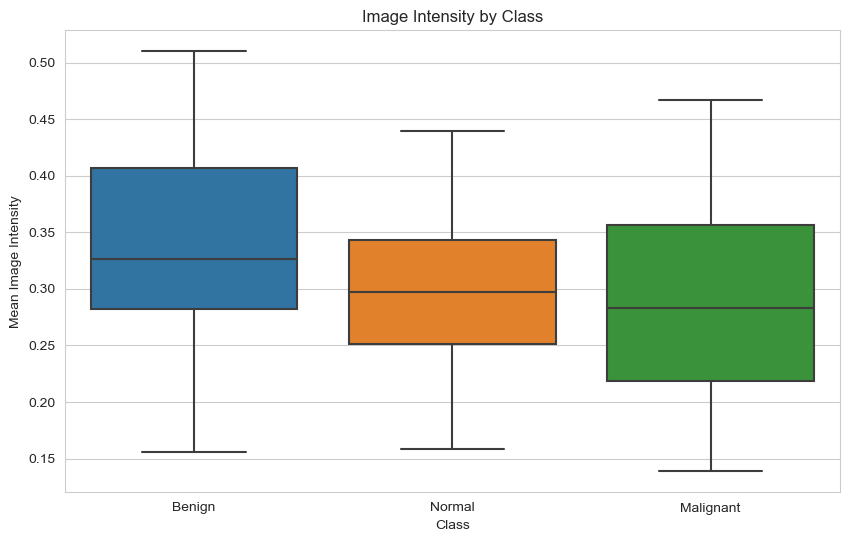

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels_dict = {0: 'Normal', 1: 'Benign', 2: 'Malignant'}

# Calculate the mean intensity values
mean_intensities = X_test.mean(axis=(1,2,3))

# Print the summary statistics for each class
for label, name in labels_dict.items():
    values = mean_intensities[y_true_classes == label]
    
    # Calculate five number summary
    min_val = np.min(values)
    q1 = np.percentile(values, 25)
    median = np.median(values)
    q3 = np.percentile(values, 75)
    max_val = np.max(values)
    
    # Calculate outliers (1.5 IQR rule)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = values[(values < lower_bound) | (values > upper_bound)]
    
    print(f"\nSummary Statistics for {name}:")
    print(f"Min: {min_val:.2f}")
    print(f"Q1 (25th Percentile): {q1:.2f}")
    print(f"Median: {median:.2f}")
    print(f"Q3 (75th Percentile): {q3:.2f}")
    print(f"Max: {max_val:.2f}")
    
    if outliers.size:
        print(f"Outliers: {outliers}")
    else:
        print("No outliers found.")

plt.figure(figsize=(10,6))
sns.boxplot(x=[labels_dict[i] for i in y_true_classes], y=mean_intensities)
plt.title('Image Intensity by Class')
plt.xlabel('Class')
plt.ylabel('Mean Image Intensity')
plt.show()


### Pie Chart of Class Distribution

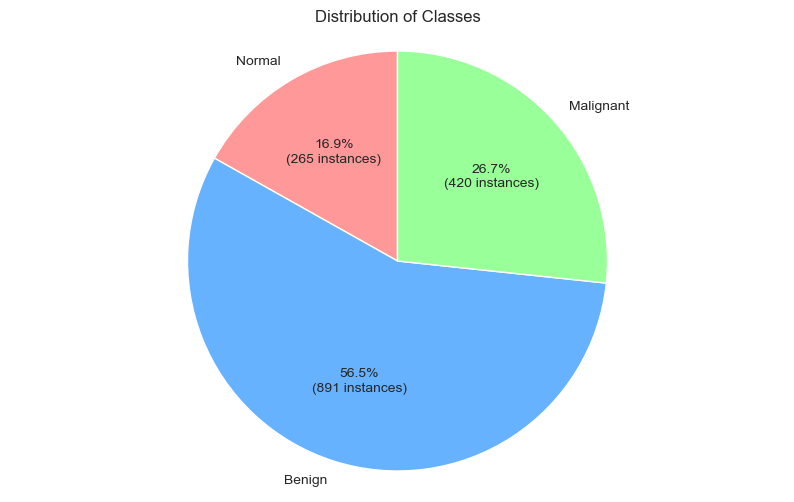

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
labels = ['Normal', 'Benign', 'Malignant']
sizes = [266, 891, 421]  # Using the provided counts for each class
colors = ['#ff9999','#66b2ff','#99ff99']

fig1, ax1 = plt.subplots(figsize=(10,6))

# Function to format labels with both counts and percentages
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} instances)".format(pct, absolute)

ax1.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: func(pct, sizes), shadow=False, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Classes')
plt.show()


### All Given Metrics

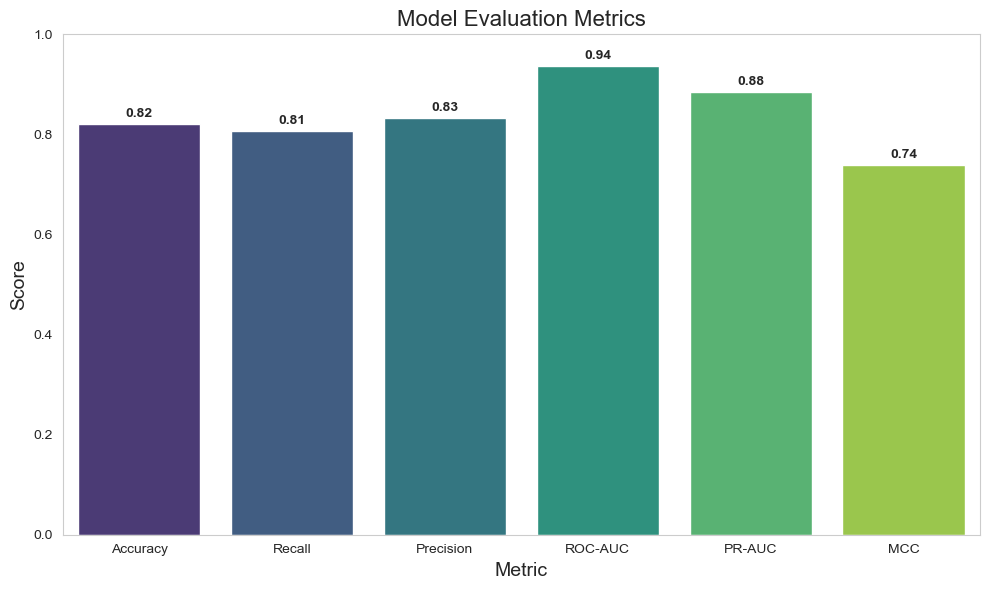

In [ ]:
import numpy as np
from sklearn.metrics import matthews_corrcoef, auc

# Extract metrics from the data dictionary
accuracy = data["Accuracy"][0]
recall_metric = data["Recall"][0]
precision_metric = data["Precision"][0]

# Compute the ROC-AUC for each class and average
roc_auc_values = [auc(fpr[i], tpr[i]) for i in range(3)]
roc_auc = np.mean(roc_auc_values)

# Average PR-AUC across the classes
pr_auc_values = [pr_auc[i] for i in range(3)]
average_prauc = np.mean(pr_auc_values)

# Compute MCC
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

# Combine all metrics for plotting
metrics_values = [accuracy, recall_metric, precision_metric, roc_auc, average_prauc, mcc]
metrics_names = ['Accuracy', 'Recall', 'Precision', 'ROC-AUC', 'PR-AUC', 'MCC']

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_names, y=metrics_values, palette="viridis")

plt.ylim(0, 1)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.grid(axis='y')

# Display the metric value on top of each bar
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Simple Preliminary Deployment

Done in app.py.